In [7]:
import numpy as np
import tensorly
from tensorly import decomposition
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from pprint import pprint

## Building Block for Tensor Decomposition: Rank-One Tensor = Vector Outer Product

An N-way tensor $\mathcal{X} \in \mathbb{R}^{I_1 \times I_2 \times \cdots I_N}$ is *rank
one* if it can be written as the outer product of $N$ vectors, i.e.,

$\mathcal{X} = \bf{a}^{(1)} \circ \bf{a}^{(2)} \circ \cdots \circ \bf{a}^{(N)}$,

where $\circ$ denotes the vector product. Each element of the tensor can thus be denoted
by the product of corresponding vector elements,

$x_{i_1i_2 \cdots i_N} = a_{i_1}^{(1)} a_{i_2}^{(2)} \cdots a_{i_n}^{(n)} \cdots
a_{i_N}^{(N)}$ for all $1 < i_n < I_N$. Here are some examples,

### Matrix Version (2-Way)

Given two vectors: $\bf{a} \in \mathbb{R}^m, \bf{b} \in \mathbb{R}^n$, then their outer product
would formulate a *rank-one* matrix $\bf{X}$,

$\bf{X} = \bf{a} \circ \bf{b} \in \mathbb{R}^{m \times n}$,

where each entry is given by,

$x_{ij} = a_i b_j$

In [9]:
a = np.random.randint(10, size=3)
b = np.random.randint(5, size=2)

X = np.outer(a, b)

def compute_rank(A, tol):
    """
    Helper function to compute the rank of a matrix using SVD.
    :param A: target matrix
    :param tol: tolerance value for floating point correction
    :return: rank of the matrix
    """
    A_outer = np.dot(A, A.T)
    A_outer_eigvals = np.linalg.eigvals(A_outer)
    return np.sum(A_outer_eigvals > tol)

print(f"Rank of the resulting matrix: {compute_rank(X, 0.000001)}")

Rank of the resulting matrix: 1


### Tensor Version (3-Way)

Given three vectors $\bf{a} \in \mathbb{R}^m, \bf{b} \in \mathbb{R}^n, \bf{c} \in
\mathbb{R}^p$, their outer products,

$ \mathcal{X} = \bf{a} \circ \bf{b} \circ \bf{c} \in \mathbb{R}^{m \times n \times p}$,

where each entry is given by,

$x_{ijk} = a_i b_j c_k$.

In [17]:
c = np.random.randint(7, size=2)

a_tensor = tensorly.tensor(a, dtype=tensorly.int64)
b_tensor = tensorly.tensor(b, dtype=tensorly.int64)
c_tensor = tensorly.tensor(c, dtype=tensorly.int64)

print(a_tensor)
print(b_tensor)
print(c_tensor)

X_tensor = tensorly.tenalg.tensor_dot(tensorly.tenalg.tensor_dot(a, b), c)

print(X_tensor)

[5 4 9]
[0 2]
[0 6]
[[[  0   0]
  [  0  60]]

 [[  0   0]
  [  0  48]]

 [[  0   0]
  [  0 108]]]


It can be seen intuitively that this is a rank one tensor.

## Tensor Multiplication: The $n$-Mode Product

The $n$-mode (matrix) product of a tensor $\mathcal{Y} \in \mathbb{R}^{J_1 \times J_2 \times \cdots \times J_N}$ with a matrix $A \in \mathbb{R}^{I \times J_n}$ is denoted by $\mathcal{Y}_{\times_n} A$,

$(\mathcal{Y}_{\times_n A})_{j_1 j_2 \cdots j_{n - 1} i j_{n + 1} \cdots j_N} = \sum_{j_{n - 1}}^{J_n} y_{j_1 j_2 \cdots j_N}a_{ij_n}$

One way of interpreting the $n$-mode multiplication can be as follows, $\mathcal{Y} \in \mathbb{R}^{I \times J \times K}, \bf{B} \in \mathbb{R}^{L \times J}$ and $\mathcal{X} = \mathcal{Y}_{\times_2} \mathbf{B}$ can be interpreted as,

> Each mode-2 fiber of $\mathcal{X}$ is the result of multiplying the correspondng mode-2 fiber of $\mathcal{Y}$ by $\bf{B}$,

$x_{i:k} = \mathbf{B} \mathcal{y}_{i:k}$, for each $i = 1, 2, \cdots, I, k = 1, 2, \cdots, K$.

In [51]:
Y = tensorly.tensor([[[1, 4, 7, 10], 
                     [2, 5, 8, 11], 
                     [3, 6, 9, 12]], 
                    [[13, 16, 19, 22], 
                     [14, 17, 20, 23], 
                     [15, 18, 21, 24]]])

A = np.array([[1, 3, 5], [2, 4, 6]])


print(tensorly.tenalg.mode_dot(Y, A, mode=1)[0,...])
print(tensorly.tenalg.mode_dot(Y, A, mode=1)[1,...])

[[ 22  49  76 103]
 [ 28  64 100 136]]
[[130 157 184 211]
 [172 208 244 280]]


## Tensor Matricization

Tensor Matricization or *unfolding*, is an operation that converts a tensor to a matrix. In order to capture
all the salient information, there are three pieces of information needed to keep track of:
1. The Size of the tensor
2. Modes that are mapped to the rows of the matrix
3. Modes that are mapped to the columns of the matrix

To perform the matricization of a tensor $\mathcal{X} \in \mathbb{R}^{I_1 \times I_2 \times \cdots \times
I_N}$, we have the partitioning of the modes $\mathcal{N} = \{1, 2, 3, \cdots, N\}$,

$$\mathcal{R} = \{r_1, r_2, \cdots, r_L\}, \mathcal{C} = \{c_1, c_2, \cdots, c_M\}$$.

Now we have the three pieces of information,

1. The size of the tensor: ote that we have $I_{\mathcal{N}} = \{I_1, I_2, \cdots, I_N\}$ denoting the size of the tensor. Hence,
the matricization of the tensor can be formulated as,

    $X_{(\mathcal{R} \times \mathcal{C}:I_{\mathcal{N}})} \in \mathbb{R}^{J \times K}$, where
$J = \Pi_{n \in \mathcal{R}} I_n$ and $K = \Pi_{n \in \mathcal{C}} I_n$.

2. Modes that are mapped to the rows of the matrix: the indices in $\mathcal{R}$ represent the modes that
are mapped to the rows of the matrix,

    $j = 1 + \sum_{l = 1}^L \Bigl[(i_{rl} - 1)\Pi_{l' = 1}^{l - 1} I_{rl'}\Bigr]$

3. Modes that are mapped to the columns of the matrix: the indices in $\mathcal{C}$ represent the modes
that are mapped to the columns of the matrix,

    $k = 1 + \sum_{m = 1}^M \Bigl[(i_{rm} - 1)\Pi_{m' = 1}^{m - 1} I_{rm'}\Bigr]$

**Example**

In [12]:
# Define a toy tensor.
Y = np.array([[[1,   4,  7,  10],
      [2,   5,  8,  11],
      [3,   6,  9,  12]],
     [[13,  16, 19, 22],
      [14,  17, 20, 23],
      [15,  18, 21, 24]]])

# Compute the unfolding.
Y_1 = tensorly.unfold(Y, mode=0)

print('Mode 1 Unfolding:\n')
pprint(Y_1)
Y_2 = tensorly.unfold(Y, mode=1)
print('\nMode 2 Unfolding:\n')
pprint(Y_2)
Y_3 = tensorly.unfold(Y, mode=2)
print('\nMode 3 Unfolding:\n')
pprint(Y_3)

# Refold the matricized tensor.
print('\nRecovered Tensor:\n')
pprint(tensorly.fold(Y_1, mode=0, shape=Y.shape))

Mode 1 Unfolding:

array([[ 1,  4,  7, 10,  2,  5,  8, 11,  3,  6,  9, 12],
       [13, 16, 19, 22, 14, 17, 20, 23, 15, 18, 21, 24]])

Mode 2 Unfolding:

array([[ 1,  4,  7, 10, 13, 16, 19, 22],
       [ 2,  5,  8, 11, 14, 17, 20, 23],
       [ 3,  6,  9, 12, 15, 18, 21, 24]])

Mode 3 Unfolding:

array([[ 1,  2,  3, 13, 14, 15],
       [ 4,  5,  6, 16, 17, 18],
       [ 7,  8,  9, 19, 20, 21],
       [10, 11, 12, 22, 23, 24]])

Recovered Tensor:

array([[[ 1,  4,  7, 10],
        [ 2,  5,  8, 11],
        [ 3,  6,  9, 12]],

       [[13, 16, 19, 22],
        [14, 17, 20, 23],
        [15, 18, 21, 24]]])


## Tensor Decomposition

Three-way decomposition.

In [13]:
# Load data.
temporal_factors = np.load("data/time_factor.npy")
neuron_factors = np.load("data/neuron_factor.npy")
trial_factors = np.load("data/trial_factor.npy")
# latent = np.load("data/latent.npy")
X = np.load("data/observed.npy")

In [14]:
def compute_factor(x, matrix1, matrix2, mode):
    coeff = tensorly.tenalg.khatri_rao([matrix1.T, matrix2.T])
    target = tensorly.unfold(x, mode=mode).T

    return coeff, target, np.linalg.solve(np.dot(coeff.T, coeff), np.dot(coeff.T, target))

def cp_als(x, r, max_iter = 20):
    B = np.random.random((r, x.shape[1]))
    C = np.random.random((r, x.shape[2]))

    for epoch in range(max_iter):
        # Compute factor matrices.
        coeff_A, target_A, A = compute_factor(x, B, C, 0)
        coeff_B, target_B, B = compute_factor(x, A, C, 1)
        coeff_C, target_C, C = compute_factor(x, A, B, 2)

        print("Epoch: ", epoch + 1, "| Loss (A): ", np.square(np.dot(coeff_A, A) - target_A).mean(),
                  "| Loss (B): ", np.square(np.dot(coeff_B, B) - target_B).mean(), "| Loss (C): ",
                  np.square(np.dot(coeff_C, C) - target_C).mean())

    return A.T, B.T, C.T

factors = cp_als(X, 3)

Epoch:  1 | Loss (A):  0.29852862431534927 | Loss (B):  0.11975193848885152 | Loss (C):  0.05150121156925428
Epoch:  2 | Loss (A):  0.011669795258027194 | Loss (B):  0.008500996021198354 | Loss (C):  0.005554100977926492
Epoch:  3 | Loss (A):  0.004651067155663795 | Loss (B):  0.0038593902827043524 | Loss (C):  0.003782599274696449
Epoch:  4 | Loss (A):  0.003183598135305046 | Loss (B):  0.0026400989621833807 | Loss (C):  0.0026065570125458435
Epoch:  5 | Loss (A):  0.0022026759888118712 | Loss (B):  0.0018545042361098152 | Loss (C):  0.001836813866172106
Epoch:  6 | Loss (A):  0.001576101991722147 | Loss (B):  0.0013528048501852635 | Loss (C):  0.0013431853764002098
Epoch:  7 | Loss (A):  0.0011711970894310944 | Loss (B):  0.001023256243542178 | Loss (C):  0.0010179503578647152
Epoch:  8 | Loss (A):  0.0008996044136818454 | Loss (B):  0.0007967519578568721 | Loss (C):  0.000793733458151217
Epoch:  9 | Loss (A):  0.0007082766830706165 | Loss (B):  0.0006331067325575677 | Loss (C):  0.0

Reconstruction Error: 6.625712961629891e-05


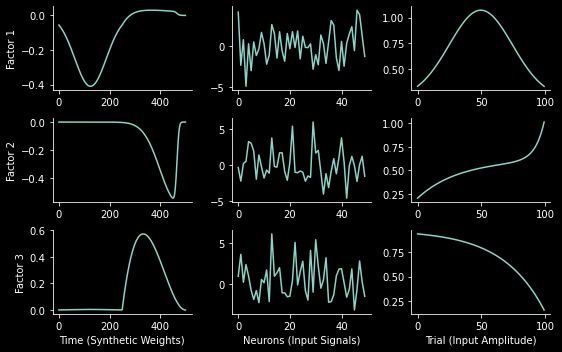

In [15]:
def r1_tensor(A, B, C):
    A = A.reshape(-1, 1)
    B = B.reshape(-1, 1)
    C = C.reshape(-1, 1)

    return np.tensordot(A * B.T, C, axes=0)[:, :, :, 0]

def recover_three_way(factor_matrices):
    A, B, C = factor_matrices
    r = A.shape[1]
    r1_tensors = np.zeros((A.shape[0], B.shape[0], C.shape[0], r))
    for i in range(r):
        r1_tensors[:, :, :, i] = r1_tensor(A[:, i], B[:, i], C[:, i])

    return r1_tensors.sum(axis=3)

def factor_plot_three_way(factor_matrices):
    A, B, C = factor_matrices
    r = A.shape[1]
    fig, axes = plt.subplots(r, 3, figsize=(8, int(r * 1.5 + 1)))
    factor_names = ["Time (Synthetic Weights)", "Neurons (Input Signals)", "Trial (Input Amplitude)"]
    for idx, (factor, axs) in enumerate(zip(factor_matrices[:3], axes.T)):
        axs[-1].set_xlabel(factor_names[idx])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i + 1))
    fig.tight_layout()

M = recover_three_way(factors)
print(f"Reconstruction Error: {np.mean((X - M)**2)}")
factor_plot_three_way(factors)